<a href="https://colab.research.google.com/github/yeondub1121/D.L-study/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# konlpy 설치 및 mecab 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

# 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# 데이터 크기 출력
print("훈련용 리뷰 개수 :", len(train_data))  # 훈련용 리뷰 개수 출력

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.2/591.2 kB 39.0 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=80fa2bb3dfa78188b5e9450814e461e31c3132d014a74ac8eda685a8992b3b70
  Stored in directory: /root/.cache/pip/wheels/62/0e/84/39e1c8bf2f2da63964fe43fb2932027d6344f8766edf28bc8c
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   513k      0  0:00:02  0:00:02 --:--:-- 1214k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/exam

In [3]:
# 상위 5개 출력
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
print("테스트용 리뷰 개수 :", len(test_data))  # 테스트용 리뷰 개수 출력

# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
print("총 샘플의 수 :", len(train_data))


테스트용 리뷰 개수 : 50000
총 샘플의 수 : 146183


   label  count
0      0  73342
1      1  72841


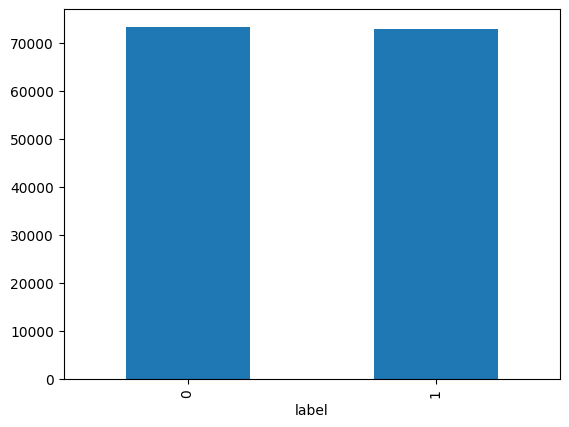

In [5]:
train_data['label'].value_counts().plot(kind='bar')
print(train_data.groupby('label').size().reset_index(name='count'))

In [6]:
# 결측치(null) 확인
print(train_data.isnull().values.any())
print(train_data.isnull().sum())

True
id          0
document    1
label       0
dtype: int64


In [7]:
# 결측치가 존재하는 행 출력
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [8]:
# Null 값 제거
train_data = train_data.dropna(how='any')  # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any())     # Null 값 존재 여부 확인
print(len(train_data))

False
146182


In [9]:
# 알파벳과 공백을 제외하고 모두 제거
eng_text = "do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@"
print(re.sub(r"[^a-zA-Z ]", '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [10]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [11]:
# 공백만 있는 데이터 제거
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True)  # white space → empty
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/tmp/ipython-input-2166475510.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [12]:
train_data.loc[train_data.document.isnull()][:5]
train_data = train_data.dropna(how='any')
print(len(train_data))

145393


In [13]:
# test_data 정제
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True)
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print("전처리 후 테스트용 샘플의 개수 :", len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/tmp/ipython-input-3184553764.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True)


In [14]:
from konlpy.tag import Mecab
mecab = Mecab()
print(mecab.morphs("와 이런것도 영화라고 차라리 뮤직비디오로 만드는 게 나을 뻔"))

stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하',
             '고', '을', '를', '인', '듯', '과', '와', '네', '들', '두', '지', '임', '게']

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]  # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sentence)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]  # 불용어 제거
    X_train.append(stopwords_removed_sentence)

X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]  # 불용어 제거
    X_test.append(stopwords_removed_sentence)


['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직', '비디오', '로', '만드', '는', '게', '나을', '뻔']


100%|██████████| 48852/48852 [00:03<00:00, 15146.00it/s]


In [15]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0, stratify=y_train
)

print('-----------훈련 데이터의 비율-----------')
print('부정 리뷰 비율 :', round(np.sum(y_train==0)/len(y_train) * 100, 3), '%')
print('긍정 리뷰 비율 :', round(np.count_nonzero(y_train)/len(y_train) * 100, 3), '%')

print('\n-----------검증 데이터의 비율-----------')
print('부정 리뷰 비율 :', round(np.sum(y_valid==0)/len(y_valid) * 100, 3), '%')
print('긍정 리뷰 비율 :', round(np.count_nonzero(y_valid)/len(y_valid) * 100, 3), '%')

print('\n-----------테스트 데이터의 비율-----------')
print('부정 리뷰 비율 :', round(np.sum(y_test==0)/len(y_test) * 100, 3), '%')
print('긍정 리뷰 비율 :', round(np.count_nonzero(y_test)/len(y_test) * 100, 3), '%')


-----------훈련 데이터의 비율-----------
부정 리뷰 비율 : 50.238 %
긍정 리뷰 비율 : 49.762 %

-----------검증 데이터의 비율-----------
부정 리뷰 비율 : 50.239 %
긍정 리뷰 비율 : 49.761 %

-----------테스트 데이터의 비율-----------
부정 리뷰 비율 : 49.808 %
긍정 리뷰 비율 : 50.192 %


In [16]:
word_list = []
for sent in X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))


총 단어수 : 45295


In [17]:
print('훈련 데이터에서 "영화" 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서 "공감" 등장 횟수 :', word_counts['공감'])

훈련 데이터에서 "영화" 등장 횟수 : 45791
훈련 데이터에서 "공감" 등장 횟수 : 756


In [18]:
# 등장 빈도수 상위 10개 단어 출력
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어 :')
print(vocab[:10])

등장 빈도수 상위 10개 단어 :
['영화', '보', '있', '없', '좋', '나', '었', '만', '는데', '너무']


In [19]:
threshold = 3
total_cnt = len(word_counts)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in word_counts.items():
    total_freq += value
    if value < threshold:
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수 :' % (threshold - 1), rare_cnt)
print('희귀 단어 비율 :', (rare_cnt / total_cnt) * 100)
print('전체 단어 중 희귀 단어 등장 비율 :', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 45295
등장 빈도가 2번 이하인 희귀 단어의 수 : 26104
희귀 단어 비율 : 57.631085108731654
전체 단어 중 희귀 단어 등장 비율 : 2.2791821400026038


In [20]:
# 희귀 단어 제거 후 단어 집합 크기
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어의 집합의 크기 :', len(vocab))

단어의 집합의 크기 : 19191


In [21]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
    word_to_index[word] = index + 2

In [22]:
vocab_size = len(word_to_index)
print("패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :", vocab_size)

print('단어 <PAD>와 매핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 매핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 매핑되는 정수 :', word_to_index['영화'])

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 19193
단어 <PAD>와 매핑되는 정수 : 0
단어 <UNK>와 매핑되는 정수 : 1
단어 영화와 매핑되는 정수 : 2


In [23]:
def texts_to_sequences(tokenized_X_data, word_to_index):
    encoded_X_data = []
    for sent in tokenized_X_data:
        index_sequences = []
        for word in sent:
            try:
                index_sequences.append(word_to_index[word])
            except KeyError:
                index_sequences.append(word_to_index['<UNK>'])
        encoded_X_data.append(index_sequences)
    return encoded_X_data


encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)


In [24]:
# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
    print(sent)

index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

[923, 1865, 128, 7, 80, 48, 34]
[2414, 3137, 4, 2094, 421, 87, 5767, 19, 306]


In [25]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']


리뷰의 최대 길이 : 74
리뷰의 평균 길이 : 12.284007084271884


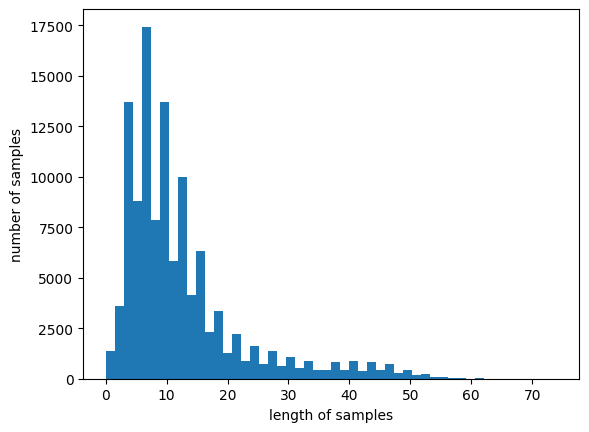

In [26]:
print('리뷰의 최대 길이 :', max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :', sum(map(len, encoded_X_train)) / len(encoded_X_train))

plt.hist([len(r) for r in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' % (max_len, (count / len(nested_list)) * 100))

In [28]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.51164950049005


In [29]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
      if len(sentence) != 0:
        features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print("훈련 데이터의 크기 :", padded_X_train.shape)
print("검증 데이터의 크기 :", padded_X_valid.shape)
print("테스트 데이터의 크기 :", padded_X_test.shape)

print("첫번째 샘플의 길이 :", len(padded_X_train[0]))
print("첫번째 샘플 :", padded_X_train[0])

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)
첫번째 샘플의 길이 : 30
첫번째 샘플 : [ 923 1865  128    7   80   48   34    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

train_label_tensor[:5]

tensor([0, 1, 1, 1, 1])

In [31]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cuda


In [32]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        # lstm_out: (batch_size, seq_length, hidden_dim)
        # hidden: (1, batch_size, hidden_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)    # (batch_size, output_dim)
        return logits

In [33]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

num_epochs = 5
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 3635


In [34]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [35]:
def calculate_accuracy(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy


def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [36]:
# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:

        # batch_X.shape == (batch_size, max_len)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

In [38]:
train_accuracy = train_correct / train_total
train_loss /= len(train_dataloader)

# Validation
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Epoch {epoch+1}/{num_epochs}:')
print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# 검증 손실이 최소일 때 체크포인트로 저장
if val_loss < best_val_loss:
    print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 10/10:
Train Loss: 0.0497, Train Accuracy: 0.9830
Validation Loss: 0.6860, Validation Accuracy: 0.8379
Validation loss improved from inf to 0.6860. 체크포인트를 저장합니다.


In [39]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.6860
Best model validation accuracy: 0.8379


In [40]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

index_to_tag = {0 : '부정', 1 : '긍정'}

Best model test loss: 0.7068
Best model test accuracy: 0.8368


In [49]:
def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = mecab.morphs(text)  # 토큰화
    tokens = [word for word in tokens if not word in stopwords]  # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor  # (1, seq_length)
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

test_input = "마지막 장면에서 눈물 났어요 최고였음"
print(predict(test_input, model, word_to_index, index_to_tag))

긍정
